### Data Reading

#### I implemented my transformer algorithm on Kaggle, adapting the data reading for non-local computation.

In [1]:
import pandas as pd

# Read the data sets
data1 = pd.read_csv("/kaggle/input/dts305/dataset1.csv", encoding="iso-8859-1")
data2 = pd.read_csv("/kaggle/input/dts305/dataset2.csv", encoding="iso-8859-1")
data3 = pd.read_csv("/kaggle/input/dts305/dataset3.csv", encoding="iso-8859-1")

# Number of printed data points
print("Number of data 1 points:", len(data1))
print("Number of data 2 points:", len(data2))
print("Number of data 3 points:", len(data3))


Number of data 1 points: 5728
Number of data 2 points: 5937
Number of data 3 points: 2225


In [2]:
data1.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
data2.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [4]:
data3.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


#### Data Cleaning

In [5]:
#Information on data1 features 
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [6]:
#Information on data2 features 
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [7]:
#Information on data3 features 
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [8]:
#To remove the NA values
data1 = data1.dropna()
print("The total number of data1-points after removing the rows with missing values are:", len(data1))

The total number of data1-points after removing the rows with missing values are: 5728


In [9]:
#To remove the NA values
data2 = data2.dropna()
print("The total number of data2-points after removing the rows with missing values are:", len(data2))

The total number of data2-points after removing the rows with missing values are: 5937


In [10]:
#To remove the NA values
data3 = data3.dropna()
print("The total number of data3-points after removing the rows with missing values are:", len(data3))

The total number of data3-points after removing the rows with missing values are: 2225


In [11]:
#explore the unique values in the categorical features to get a clear idea of the data1.
print("Total categories in the feature spam:\n", data1["spam"].value_counts(), "\n")


Total categories in the feature spam:
 spam
0    4360
1    1368
Name: count, dtype: int64 



In [12]:
#explore the unique values in the categorical features to get a clear idea of the data2.
print("Total categories in the feature Emotion:\n", data2["Emotion"].value_counts(), "\n")


Total categories in the feature Emotion:
 Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64 



In [13]:
#explore the unique values in the categorical features to get a clear idea of the data2.
print("Total categories in the feature Label:\n", data3["Label"].value_counts(), "\n")


Total categories in the feature Label:
 Label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64 



In [14]:
# View dataset column names
print(data1.columns)
print(data2.columns)
print(data3.columns)

Index(['text', 'spam'], dtype='object')
Index(['Comment', 'Emotion'], dtype='object')
Index(['Text', 'Label'], dtype='object')


### Transformer Algorithm

In [15]:
import torch
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import warnings

warnings.filterwarnings("ignore")


In [16]:
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


### Feature Processing

In [17]:
# Rename columns for consistency
data2 = data2.rename(columns={'Comment': 'text'})
data3 = data3.rename(columns={'Text': 'text'})

# Create label mapping for data1
label_map1 = {0: 0, 1: 1}

# Create label mapping for unique emotions in data2
label_map2 = {label: idx for idx, label in enumerate(data2['Emotion'].unique())}

# Create label mapping for unique labels in data3
label_map3 = {label: idx for idx, label in enumerate(data3['Label'].unique())}

# Map spam labels in data1 to new labels
data1['spam'] = data1['spam'].map(label_map1)

# Map emotion labels in data2 to new labels
data2['Emotion'] = data2['Emotion'].map(label_map2)

# Map label values in data3 to new labels
data3['Label'] = data3['Label'].map(label_map3)


In [18]:
from transformers import AutoTokenizer

# Load the pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    # Tokenize the input text with padding and truncation
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)


In [19]:
def tokenize_encode_dataset(data, label_column):
    # Extract text and labels from the dataset
    texts = data['text'].tolist()
    labels = data[label_column].tolist()
    
    # Tokenize the texts with padding and truncation
    encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=128)  # You can adjust max_length
    return encodings, labels

def create_dataset(data, label_column):
    # Tokenize and encode the dataset
    encodings, labels = tokenize_encode_dataset(data, label_column)
    
    # Create a Dataset object from the encodings and labels
    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })
    return dataset

# Create datasets for each of the three datasets
datasets = {
    'dataset1': create_dataset(data1, 'spam'),
    'dataset2': create_dataset(data2, 'Emotion'),  
    'dataset3': create_dataset(data3, 'Label')
}


In [20]:
print(data1.columns)  # Should display: ['text', 'spam']
print(data2.columns)  # Should display: ['text', 'Emotion']
print(data3.columns)  # Should display: ['text', 'Label']


Index(['text', 'spam'], dtype='object')
Index(['text', 'Emotion'], dtype='object')
Index(['text', 'Label'], dtype='object')


In [21]:
# Split the datasets into training and validation sets
train_datasets = {}
val_datasets = {}
for name, dataset in datasets.items():
    # Split the dataset with a test size of 30%
    split_dataset = dataset.train_test_split(test_size=0.3)
    train_datasets[name] = split_dataset['train']  # Store the training set
    val_datasets[name] = split_dataset['test']    # Store the validation set


In [22]:
training_args = TrainingArguments(
    output_dir='./results',            # Directory to save the results
    num_train_epochs=10,               # Keep 10 epochs
    per_device_train_batch_size=128,   # batch size for training
    per_device_eval_batch_size=128,    # batch size for evaluation
    learning_rate=2e-5,                # Adjusted learning rate
    warmup_steps=500,                   # Increased number of warmup steps
    weight_decay=0.01,                 # Regularization
    logging_dir='./logs',               # Directory to save logs
    logging_steps=100,                  # Log every 100 steps
    evaluation_strategy='steps',        # Evaluation strategy based on steps
    eval_steps=500,                     # Evaluate every 500 steps
    save_steps=500,                     # Save the model every 500 steps
    load_best_model_at_end=True,       # Save the best performing model
)


In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    # Unpack the evaluation predictions into logits and labels
    logits, labels = eval_pred
    
    # Convert logits to a tensor
    logits = torch.tensor(logits)  
    
    # Get the predicted class by taking the argmax of logits
    predictions = torch.argmax(logits, dim=-1)
    
    # Calculate accuracy
    acc = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [24]:
from transformers import BertForSequenceClassification

# Load the regular BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder and transform the 'spam' column
encoder1 = LabelEncoder()
data1['spam'] = encoder1.fit_transform(data1['spam'])

# Set the number of labels in the model configuration to 2 (for binary classification)
model.config.num_labels = 2  # 2 classes

# Initialize the Trainer with the model, training arguments, and datasets
trainer1 = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['dataset1'],
    eval_dataset=datasets['dataset1'],
    compute_metrics=compute_metrics
)

# Start training the model
trainer1.train()

# Evaluate the model after training
eval_results1 = trainer1.evaluate()
print(f"Evaluation results for dataset1: {eval_results1}")


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xiangyu-cui21 (xiangyu-cui21-xi-an-jiaotong-liverpool-university). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


Evaluation results for dataset1: {'eval_loss': 0.004273663740605116, 'eval_accuracy': 0.9994762569832403, 'eval_precision': 0.9994766171090826, 'eval_recall': 0.9994762569832403, 'eval_f1': 0.9994760595906605, 'eval_runtime': 22.4826, 'eval_samples_per_second': 254.775, 'eval_steps_per_second': 1.023, 'epoch': 10.0}


In [26]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Encode the 'Emotion' column to ensure three classes are handled correctly
encoder2 = LabelEncoder()
data2['Emotion'] = encoder2.fit_transform(data2['Emotion'])

# Initialize the Trainer for the second dataset
trainer2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['dataset2'],
    eval_dataset=datasets['dataset2'],
    compute_metrics=compute_metrics
)

# Start training the model
trainer2.train()

# Evaluate the model after training
eval_results2 = trainer2.evaluate()
print(f"Evaluation results for dataset2: {eval_results2}")


Step,Training Loss,Validation Loss


Evaluation results for dataset2: {'eval_loss': 0.12244415283203125, 'eval_accuracy': 0.965470776486441, 'eval_precision': 0.9665035032751481, 'eval_recall': 0.965470776486441, 'eval_f1': 0.9656445869685735, 'eval_runtime': 23.3121, 'eval_samples_per_second': 254.674, 'eval_steps_per_second': 1.03, 'epoch': 10.0}


In [28]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Encode the 'Label' column to ensure five classes are handled correctly
encoder3 = LabelEncoder()
data3['Label'] = encoder3.fit_transform(data3['Label'])

# Initialize the Trainer for the third dataset
trainer3 = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['dataset3'],
    eval_dataset=datasets['dataset3'],
    compute_metrics=compute_metrics
)

# Start training the model
trainer3.train()

# Evaluate the model after training
eval_results3 = trainer3.evaluate()
print(f"Evaluation results for dataset3: {eval_results3}")


Step,Training Loss,Validation Loss


Evaluation results for dataset3: {'eval_loss': 1.097182035446167, 'eval_accuracy': 0.6755056179775281, 'eval_precision': 0.7764877753948537, 'eval_recall': 0.6755056179775281, 'eval_f1': 0.6152197931128706, 'eval_runtime': 8.7821, 'eval_samples_per_second': 253.357, 'eval_steps_per_second': 1.025, 'epoch': 10.0}


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()


In [31]:
import numpy as np

# Get the model's predictions on the validation set
preds1 = trainer1.predict(datasets['dataset1'])
logits1, labels1 = preds1.predictions, preds1.label_ids
predictions1 = np.argmax(logits1, axis=-1)


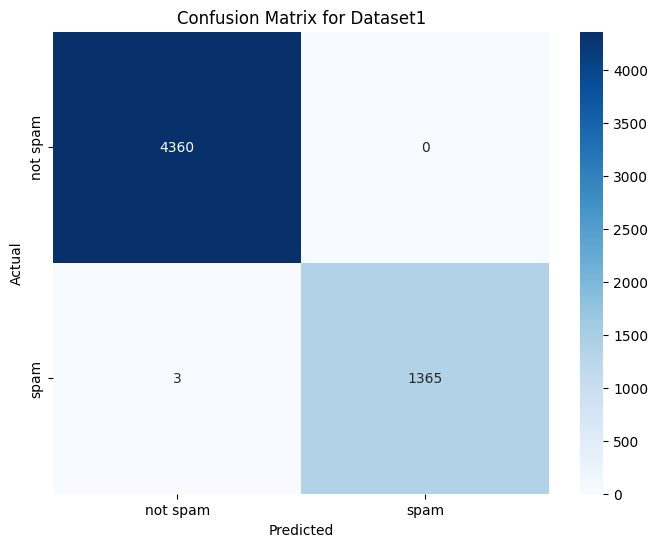

In [32]:
# Plot the confusion matrix
plot_confusion_matrix(labels1, predictions1, class_names=['not spam', 'spam'], dataset_name="Dataset1")

In [33]:
# Get the model's predictions on the validation set
preds2 = trainer2.predict(datasets['dataset2'])
logits2, labels2 = preds2.predictions, preds2.label_ids
predictions2 = np.argmax(logits2, axis=-1)


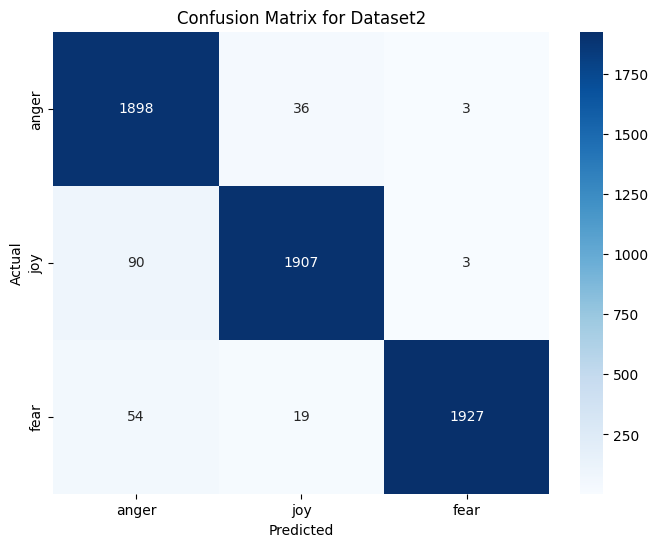

In [34]:
# Plot the confusion matrix
plot_confusion_matrix(labels2, predictions2, class_names=['anger', 'joy', 'fear'], dataset_name="Dataset2")

In [35]:
# Get the model's predictions on the validation set
preds3 = trainer3.predict(datasets['dataset3'])
logits3, labels3 = preds3.predictions, preds3.label_ids
predictions3 = np.argmax(logits3, axis=-1)


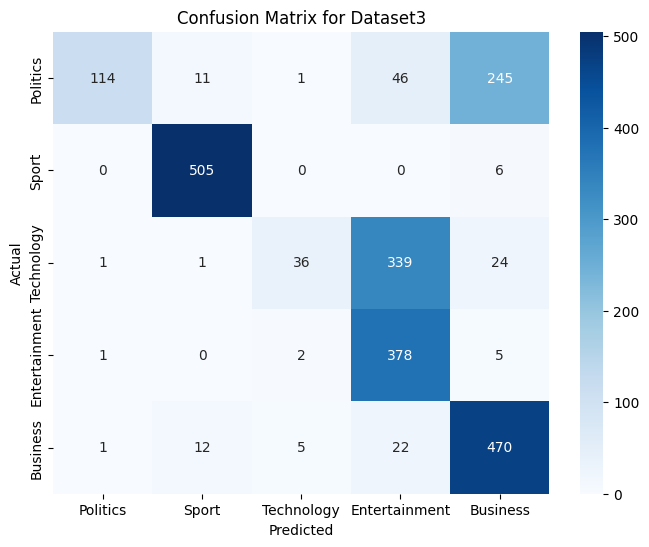

In [36]:
# Plot the confusion matrix
plot_confusion_matrix(labels3, predictions3, class_names=['Politics', 'Sport', 'Technology', 'Entertainment', 'Business'], dataset_name="Dataset3")
